In [1]:
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
import math
import string
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
import json
import gzip
from urllib.request import urlopen

# Data preparation

We will use a dataset consisting of food product reviews on Amazon.com [source](http://jmcauley.ucsd.edu/data/amazon/).

In [2]:
products = pd.read_csv('food_products.csv')
print(len(products))
products.iloc[1]['review']

2500


'I found these in a Mitsuwa Marketplace in Illinois.I actually expected them to taste better than the did.  they were okay but seem smaller than standard kit kats and the taste was a tad mild compared to other green tea candies I have tried.But still, they were pleasant enough and nice for a change.'

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [3]:
products = products[products['rating'] != 3]
len(products)

1729

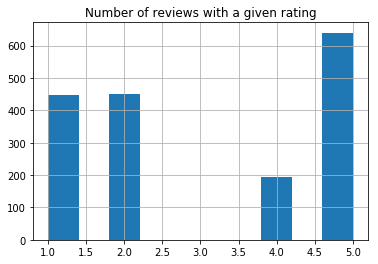

In [4]:
plt.title('Number of reviews with a given rating')
products['rating'].hist()

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [5]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products[0:20]

,Unnamed: 0,summary,review,rating,sentiment
2,9,Not a fan,"I love green tea, I love Kit Kats, but the two...",1.0,-1
4,20,Thai curry is the way to go to add spice to an...,So many flavors. I can't begin to tell you how...,5.0,1
5,28,Delicious,I have tried all the curris from Mae Ploy (exc...,5.0,1
7,32,Not natural/organic at all,This product is no where near natural / organi...,1.0,-1
9,46,They work well enough.,"There's a vague taste of apple cinnamon, but m...",4.0,1
11,49,Lessens the effects of an asthma attack,If my wife drinks a cup of this tea when she f...,5.0,1
13,54,Dark Chocolate Toffee Nut - fantastic flavor! ...,I really enjoy PowerBar ProteinPlus bars - but...,5.0,1
15,63,Nostalgia,"I was born in the 80's, and this was brought i...",5.0,1
16,65,great,my niece teaches underprivileged kids in flori...,5.0,1
17,75,Not soft at all. Basically same as cheap licor...,"Licorice is my favorite candy, and it promotes...",1.0,-1


Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

## Build the word count vector for each review

Let us explore a specific example of a food product.

In [6]:
products.iloc[21]

Unnamed: 0                                                  162
summary                                                Not good
review        unsure if I just got a bad batch or what...the...
rating                                                        1
sentiment                                                    -1
Name: 37, dtype: object

Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.


In [7]:
def remove_punctuation(text):
    if type(text) != str:
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

products['review_clean'] = products['review'].apply(remove_punctuation)

Now, let us explore what the sample example above looks like after these 2 transformations.

In [8]:
word_count = []

for i in range(0,len(products)):
    word_count_dict = {}
    review_clean = products['review_clean'].iloc[i]
    review_clean = review_clean.split(' ')
    for word in review_clean:
        if word in word_count_dict.keys():
            word_count_dict[word] += 1
        else:
            word_count_dict[word] = 1
    word_count.append(word_count_dict)

products['word_count'] = word_count

In [9]:
# Create a DictVectorizer and create vectors for these dictionaries
dictVectorizer = DictVectorizer()
features_Frame = dictVectorizer.fit_transform(products['word_count'])

In [10]:
#  Create a new DataFrame that has all these features as columns plus the sentiment label!
product_data = pd.DataFrame(features_Frame.toarray())
product_data['sentiment'] = list(products['sentiment'])
product_data['review_clean'] = list(products['review_clean'])  # to display later
product_data['summary'] = list(products['summary'])  # to display later
product_data.head()

,0,1,2,3,4,5,6,7,8,9,...,13745,13746,13747,13748,13749,13750,13751,sentiment,review_clean,summary
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,I love green tea I love Kit Kats but the two d...,Not a fan
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,So many flavors I cant begin to tell you how m...,Thai curry is the way to go to add spice to an...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,I have tried all the curris from Mae Ploy excl...,Delicious
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,This product is no where near natural organic...,Not natural/organic at all
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Theres a vague taste of apple cinnamon but mos...,They work well enough.


## Split data into training, validation and test sets.

Let's perform a train/validation/test split with 80% of the data in the training set, 10% of the data in the validation set, 10% test. We use `random_state = 1` so that everyone gets the same result.

In [11]:
train_data, test_data = train_test_split(product_data, test_size = 0.2, random_state = 1)
validation_data, test_data = train_test_split(test_data, test_size = 0.5, random_state = 1)

## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. Given a classification problem with 2 classes, the majority class classifier has at least 50% accuracy.

In [14]:
from sklearn.dummy import DummyClassifier
maj_model = DummyClassifier(strategy = 'most_frequent').fit(validation_data[features], validation_data['sentiment'])
dummy_predictions = maj_model.predict(validation_data[features])

# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count** as a feature and the column **sentiment** as the target. sklearn.LogisticRegression (documentation here) uses a value named c for the regularization hyper-parameter where  𝑐=1𝜆 . This means a really large value of c corresponds to a very small  𝜆 .

**Note:** This line may take a few minutes.

In [13]:
features = list(train_data.columns)
features.remove('sentiment')
features.remove('review_clean')
features.remove('summary')

#Note: C = 1/Lambda. Setting C to a really high value is the same as setting lambda = 0
sentiment_model = LogisticRegression(penalty='l2', random_state = 1, C = 1e23)
sentiment_model.fit(train_data[features], train_data['sentiment'])

LogisticRegression(C=1e+23, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Let's look at some of the coefficients and the corresponding words. The weights are stored in a `coef_` object: 

In [15]:
weights = sentiment_model.coef_[0]

The words are stored in the Vectorizer object:


In [16]:
feature_names = dictVectorizer.get_feature_names()

In [17]:
min = float('inf')
index = 0
for i in range(0,len(feature_names)):
    temp_weight = weights[i]
    if temp_weight < min:
        min = temp_weight
        index = i
        
print(min)
feature_names[index]

-4.43231019277679


'Not'

## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **validation data**. In this section, we will explore this in the context of 3 examples in the validation dataset.  We refer to this set of 3 examples as the **sample_data**.

In [18]:
sample_data = validation_data[10:13]
sample_data

,0,1,2,3,4,5,6,7,8,9,...,13745,13746,13747,13748,13749,13750,13751,sentiment,review_clean,summary
60,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,When I was incarcerated in a Mexican prison th...,taste is awful
1557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,a good buy for walnut piecesA known brand name...,a good buy fo walnut pieces...
733,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,Theres a lot of talk about echinacea being a l...,"There Ought To Be No ""U"" (or ""K"") in Yogi"


### Predicting sentiment


In [19]:
print ("Probability predictions on the sample data:")
print('Negative Sentiment  Positive Sentiment')
print(sentiment_model.predict_proba(sample_data[features]))

Probability predictions on the sample data:
Negative Sentiment  Positive Sentiment
[[9.99978293e-01 2.17069729e-05]
 [8.58944142e-05 9.99914106e-01]
 [5.18998052e-07 9.99999481e-01]]


In [20]:
print(sentiment_model.predict(sample_data[features]))

[-1  1  1]


# Find the most positive (and negative) review

We now turn to examining the full **validation_data** dataset <span style="color:red">(not sample_data)</span>, , and use `sklearn` to form predictions on all of the data points for faster performance.

Using the `sentiment_model`, find review/reviews in the **validation_data** with the **highest probability** of being classified as a **positive review**. We refer to this as the "most positive review."

In [21]:
review_probs = sentiment_model.predict_proba(validation_data[features])
negative_reviews = [row[0] for row in review_probs]
positive_reviews = [row[1] for row in review_probs]
most_positive_review = max(positive_reviews)
most_negative_review = max(negative_reviews)
index = 0
min_index = 0

for i in range(0, len(positive_reviews)):
    if positive_reviews[i] == most_positive_review:
        index = i
        break

for i in range(0, len(negative_reviews)):
    if negative_reviews[i] == most_negative_review:
        min_index = i
        break


# best review - peanuts
# worst review - Annies something

# Create a confusion matrix

Recall that there are four values associated with a confusion matrix: true positive, true negative, false positive, and false negative which we will abberviate as TP, TN, FP, and FN, respecitvely. 

In [22]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])
    
    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])


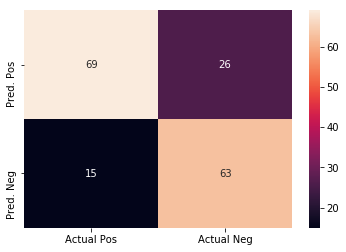

In [23]:
pred_sentiments = sentiment_model.predict(validation_data[features])
true_sentiments = validation_data['sentiment']
tp = 0
fp = 0
tn = 0
fn = 0
count = 0

for val in true_sentiments:
    if val == 1:
        if pred_sentiments[count] == 1:
            tp = tp + 1
            count = count + 1
        else:
            fn = fn + 1
            count = count + 1
    else:
        if pred_sentiments[count] == -1:
            tn = tn + 1
            count = count + 1
        else:
            fp = fp + 1
            count = count + 1
            
plot_confusion_matrix(tp, fp, fn, tn)

# Calculating Accuracy

Now that we have succesfully trained a model, let's compare the accuracy of the sentiment_model to that of the baseline classifier.

Below, calculate the accuracy of each model using sklearn's [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function.

In [85]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(true_sentiments, pred_sentiments)
dummy_ac = accuracy_score(true_sentiments, dummy_predictions)
dummy_ac

0.5144508670520231

### Logistic Regression with L2 regularization


Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.


In [54]:
l2_penalties = [1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = ['coefficients [L2=1]', 'coefficients [L2=4]', 'coefficients [L2=10]', 
                    'coefficients [L2=1e2]', 'coefficients [L2=1e3]', 'coefficients [L2=1e5]']

# Add the coefficients to this table for each model
table = pd.DataFrame(columns = ['word'] + l2_penalty_names)
table['word'] = feature_names

for l2_penalty, column_name in zip(l2_penalties, l2_penalty_names):
    model = LogisticRegression(penalty='l2', random_state = 1, C = 1/l2_penalty, fit_intercept = False)
    model.fit(train_data[features], train_data['sentiment'])
    cfs = model.coef_[0]
    table[column_name] = cfs

table.head()

,word,coefficients [L2=1],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3],coefficients [L2=1e5]
0,,0.039937,0.030597,0.027102,0.026090,0.019582,-0.000500
1,0,0.137753,0.108966,0.087793,0.029444,0.003514,0.000027
2,0000,0.045107,0.023884,0.013162,0.002197,0.000387,0.000005
3,002,-0.001946,-0.001643,-0.001363,-0.000672,-0.000173,-0.000004
4,004,-0.001946,-0.001643,-0.001363,-0.000672,-0.000173,-0.000004


## Look at the Coefficients

We'll now look at the **coefficients** for the model that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

In [86]:
temp = table[['word', 'coefficients [L2=1]']]
positive_words = temp.nlargest(5, 'coefficients [L2=1]').word
negative_words = temp.nsmallest(5, 'coefficients [L2=1]').word
print(negative_words)
print(positive_words)

2501        Not
4673      bland
12961     tried
9564        not
4657     bitter
Name: word, dtype: object
7620        great
6538         easy
1693        Great
4598         best
6056    delicious
Name: word, dtype: object


Let us observe the effect of increasing L2 penalty on the 10 words just selected.

In [80]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, list(table_positive_words.iloc[i]),
                 '-', label=positive_words.iloc[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, list(table_negative_words.iloc[i]),
                 '-', label=negative_words.iloc[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -3, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

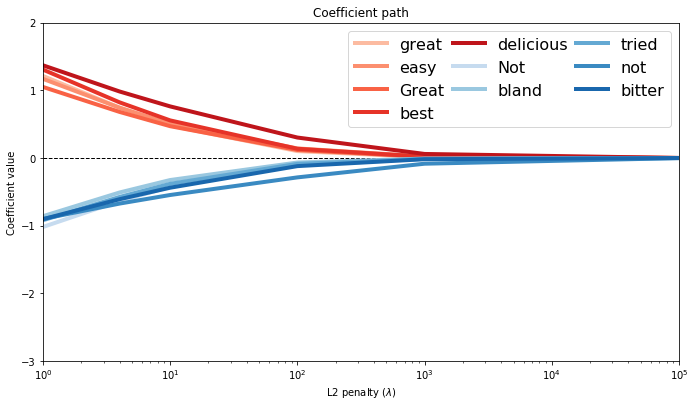

In [81]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[1, 4, 10, 1e2, 1e3, 1e5])

Calculate how the accuracy on the validation data changes with the increase of the l2 penalty. 

In [84]:
# TODO
for l2_penalty in l2_penalties:
    model = LogisticRegression(penalty='l2', random_state = 1, C = 1/l2_penalty, fit_intercept = False)
    model.fit(train_data[features], train_data['sentiment'])
    predictions = model.predict(test_data[features])
    print('Accuracy is ' + str(accuracy_score(test_data['sentiment'], predictions)))

Accuracy is 0.8208092485549133
Accuracy is 0.8092485549132948
Accuracy is 0.8034682080924855
Accuracy is 0.7687861271676301
Accuracy is 0.7052023121387283
Accuracy is 0.5664739884393064
